# Spectral Clustering

In this notebook, the robustness of the method chosen in the Callaham paper is tested by exploring spectral clustering for unsupervised dominant balance identification. Spectral clustering functions by constructing a graph network between points based on a defined condition, which means it does not rely on Eulcidean Distance [Spectral CLustering](https://en.wikipedia.org/wiki/Spectral_clustering). This means it better able to handle different sized and shaped clusters. However, it does not have the capacity to take in new data points after training, which brings a computational cost difficulty.

First, we do the same preprocessing done for the Boundary_Layer notebook. We'll get the data and the derivatives and obtain the equation space representation of the terms.

In [41]:
import numpy as np
from numpy.random import randint
import h5py
import sys
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import SparsePCA
from joblib import Parallel, delayed

# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs
import preprocessing as pp

# 1. Preprocessing

## a. Load the data

In [42]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [43]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u_bar = np.array(file["um"])
v_bar = np.array(file["vm"])
p_bar = np.array(file["pm"])
R_uu = np.array(file["uum"]) - u_bar**2
R_uv = np.array(file["uvm"]) - u_bar * v_bar
R_vv = np.array(file["uvm"]) - v_bar**2

In [44]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [45]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

In [46]:
# Get y space steps:
# The y step is not constant, so we need to calculate it for each point
dy = np.diff(y[::-1])
dy = np.append(dy, dy[-1])

# Get the derivatives
u_x, u_y, lap_u, v_y, p_x, R_uux, R_uvy = pp.get_derivatives_numpy(
    nx, ny, dx, y, u_bar, y, p_bar, R_uu, R_uv
)

# Flatten arrays for matrix multiplication, using fortran ordering
u_bar = u_bar.flatten("F")
v_bar = v_bar.flatten("F")
p_bar = p_bar.flatten("F")
R_uu = R_uu.flatten("F")
R_uv = R_uv.flatten("F")

# Flatten the derivative terms arrays for the rest of the notebook
lap_u = lap_u.flatten("F")
R_uux = R_uux.flatten("F")
R_uvy = R_uvy.flatten("F")
u_x = u_x.flatten("F")
u_y = u_y.flatten("F")
v_y = v_y.flatten("F")
p_x = p_x.flatten("F")

## c. Equation space representation

In [47]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [48]:
# Get terms stored as features, keeping track of the space position
X_flat = X.flatten("F")
Y_flat = Y.flatten("F")
features = (
    1e3
    * np.vstack(
        [
            u_bar * u_x,
            v_bar * u_y,
            p_x,
            nu * lap_u,
            R_uvy,
            R_uux,
            1e-3 * X_flat,
            1e-3 * Y_flat,
        ]
    ).T
)
nfeatures = features.shape[1] - 2

# 2. Spectral Clustering


Spectral clustering is a clustering technique which starts by constructing a similarity graph, where nodes represent data points, and edges represent their similarities, through the fact that they are connected. This defines a graph which is then transformed into a graph Laplacian matrix. Using the largest eigenvalues of that matrix, a lower dimensional embedding of the data is obtained. These eigenvectors are then used as features to cluster the data points using a standard algorithm such as k-means. Because it relies on this embedding which does not rely solely on Euclidean distance, Spectral Clustering deals well with differently shaped clusters [Spectral CLustering](https://en.wikipedia.org/wiki/Spectral_clustering).
 
Due to computational cost, the model is trained and used only on a subset of the data. One can use a computer with large amounts of memory to run this for a larger fraction of the dataset.

## a. Train and predict model

In [49]:
# Initialise the Spectral Clustering model
nc = 6  # Number of clusters
seed = 75016  #  Keep a seed for debugging/plotting
np.random.seed(seed)
model = SpectralClustering(
    n_clusters=nc, affinity="nearest_neighbors", n_neighbors=8, random_state=seed
)

In [50]:
# Train on only a subset of the data
sample_pct = 0.01
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]
features_sc = features[mask, :]
model.fit_predict(features_sc[:, :6])

array([5, 5, 1, ..., 5, 2, 2], dtype=int32)

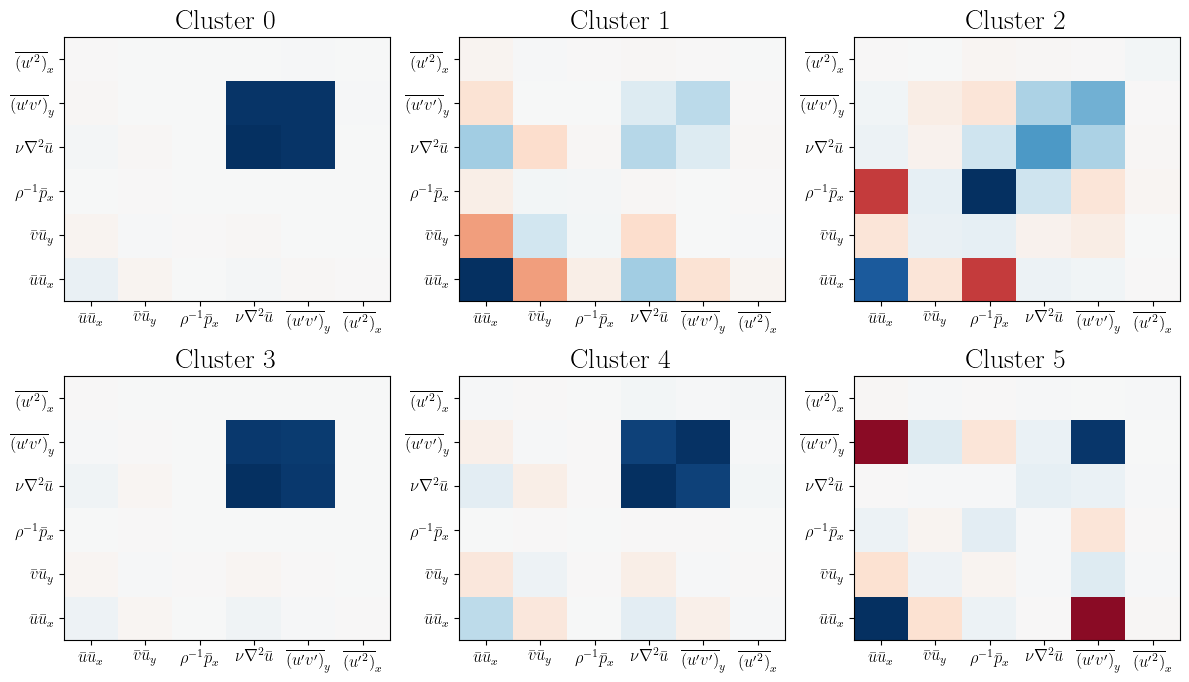

In [51]:
# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = model.labels_ == i
    covs[i, :, :] = np.cov(features_sc[mask_, :6].T)

# Plot the covariances
pf.plot_cov_mat(covs, nfeatures, nc, labels, "Other", f"BL/SC_CovMat_{nc}")

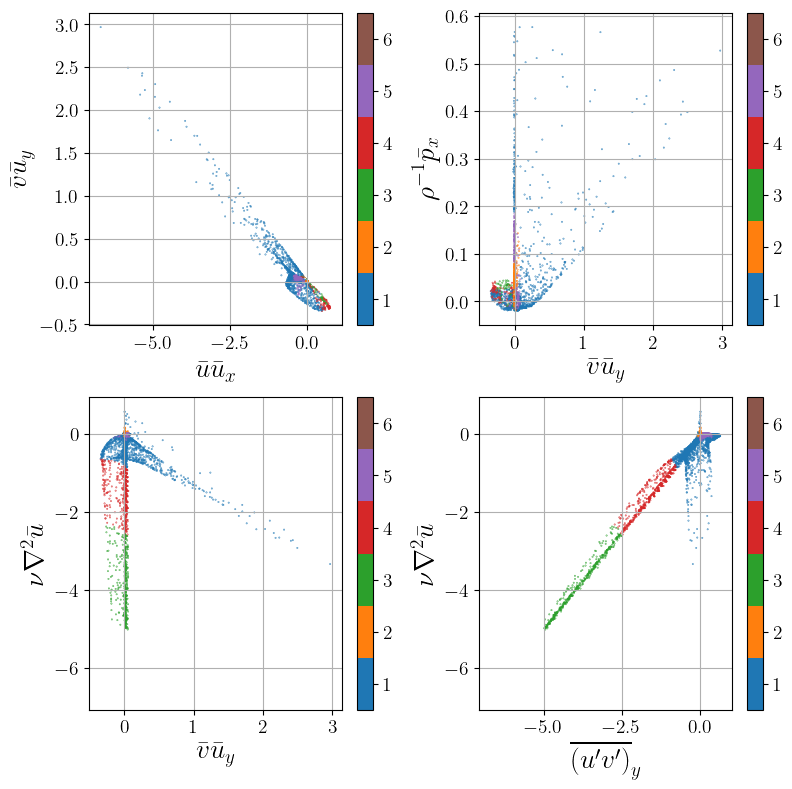

In [52]:
# Visualize spectral clustering with 2D views of equation space
cluster_idx = model.labels_

pf.plot_clustering_2d_eq_space(
    features_sc[:, :6], cluster_idx, nc, f"BL/SC_2D_eq_space_{nc}"
)

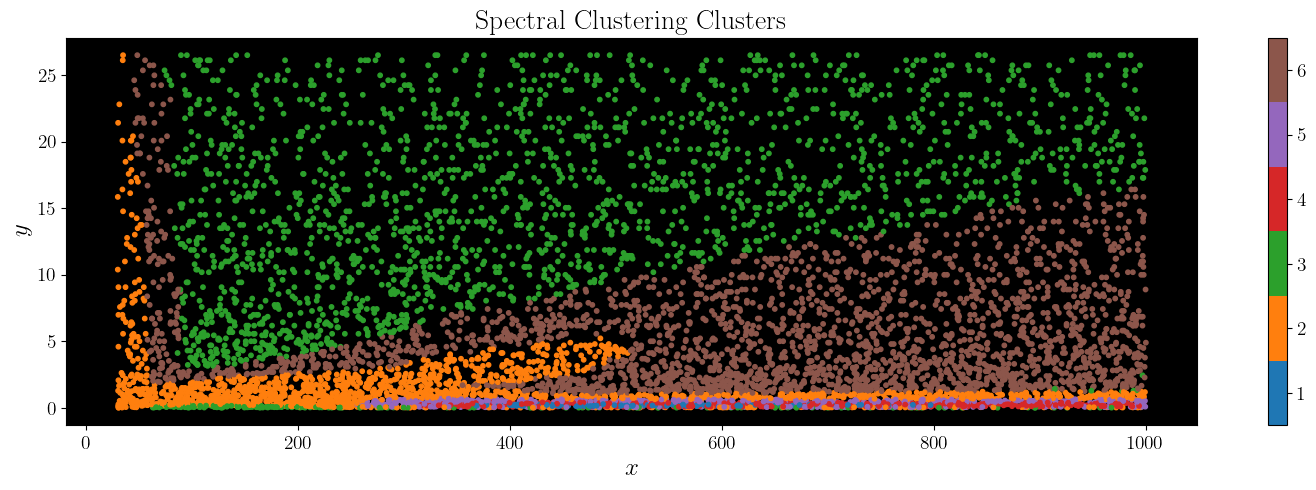

In [53]:
# Plot these points in physical space
pf.scatter_clustering_space(
    features_sc[:, 6],
    features_sc[:, 7],
    cluster_idx,
    nc,
    f"BL/SC_clustering_space_{nc}",
)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

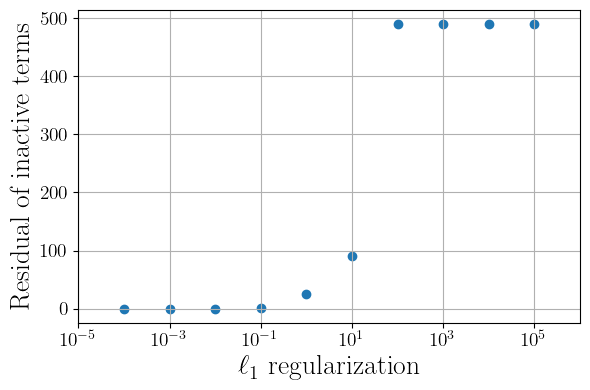

In [54]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :6]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, nc) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err, f"BL/SC_spca_residuals_{nc}")

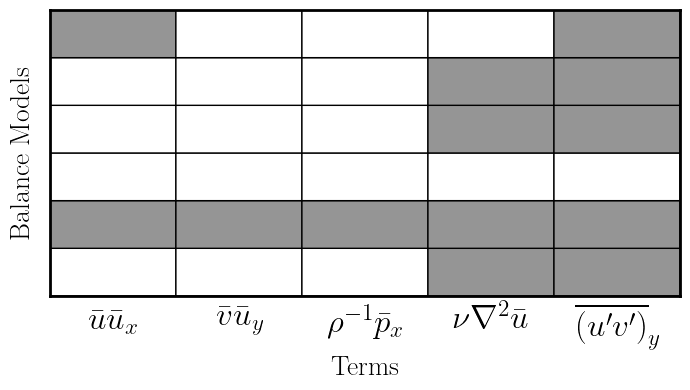

In [55]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 1  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features_sc[feature_idx, :6]

    spca = SparsePCA(
        n_components=1, alpha=alpha_opt, random_state=seed
    )  # normalize_components=True
    spca.fit(cluster_features)

    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

# Plot the active terms for each cluster
pf.plot_balance_models(
    spca_model, labels, False, f"BL/SC_active_terms_{nc}_{alpha_opt}"
)

## c. Resulting Final Dominant Balance Models

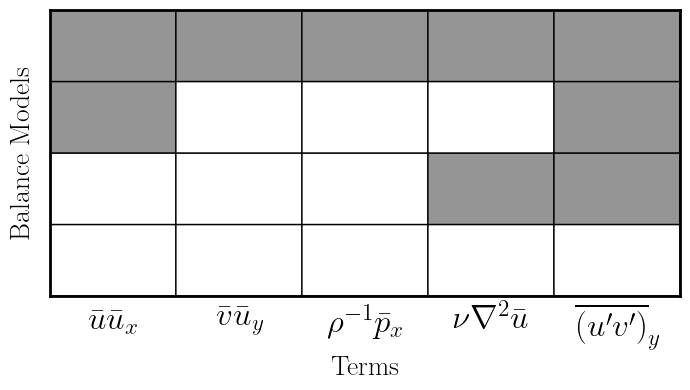

In [56]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])

pf.plot_balance_models(
    balance_models, labels, False, f"BL/SC_final_active_terms_{nc}_{alpha_opt}"
)

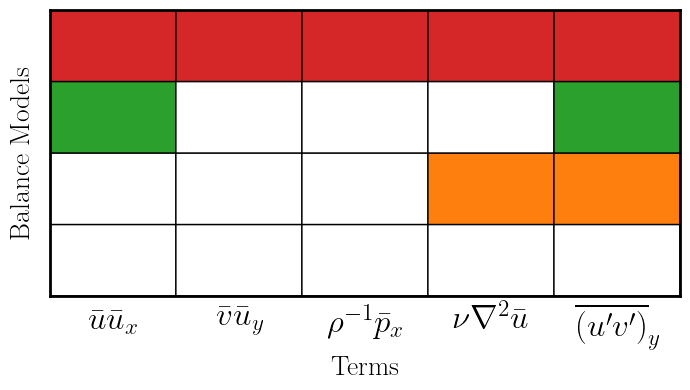

In [57]:
pf.plot_balance_models(
    balance_models, labels, True, f"BL/SC_balance_models_{nc}_{alpha_opt}"
)

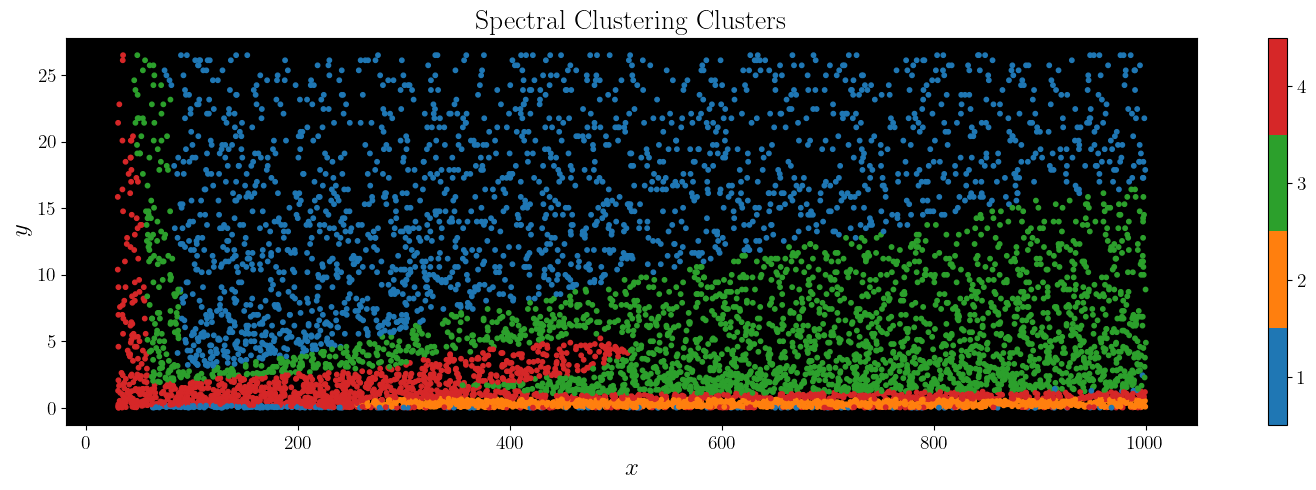

In [58]:
# Plot the clustering in space
pf.scatter_clustering_space(
    features_sc[:, 6],
    features_sc[:, 7],
    balance_idx,
    nmodels,
    f"BL/SC_spca_clustering_space_{nc}_{alpha_opt}",
)

Here, a different optimal complexity value was used for the SPCA,

Similar dominant balance regimes are identified, though they have some differences.

## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

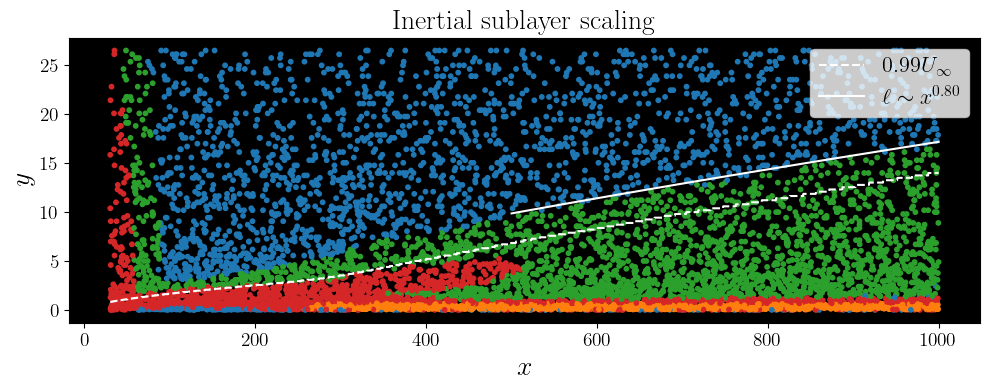

In [59]:
# Define some variables
u_map = np.reshape(u_bar, (ny, nx), order="F")

x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends (based on resutls with GMM)

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]


# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b
x_to_fit = x_layer > x_turb  # End of transitional region
gmm_fit = power_law(x_layer, 0.06832071, 0.80)  # Fit from the GMM results

# Plot the inertial sublayer scaling
pf.scatter_sublayer_scaling(
    x,
    features_sc[:, 6],
    features_sc[:, 7],
    balance_idx,
    delta,
    x_layer,
    gmm_fit,
    x_to_fit,
    f"BL/SC_sublayer_scaling_{nc}_{alpha_opt}",
)

Here, we see that the inertial sublayer identified (orange) does indeed have it's vertical extent that follows the power law.

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (blue) is approximately constant in the fully-developed turbulent region. 

And we see that it has y extent: $y \sim 1$

Converting this to $y^{+}$, we get:

$y^{+} \sim 36$

As seen below.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

In [60]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * u_y[::ny])
y_plus = np.outer(1, u_tau / nu)
print(y_plus.shape)
x_plt = [600, 700, 800, 900, x[-3]]
for i in range(5):
    x_idx = np.nonzero(x > x_plt[i])[0][0]
    print(y_plus[:, x_idx])

(1, 3320)
[37.79330512]
[36.77106233]
[35.96880357]
[35.2770483]
[34.72287067]


Here, we see that the identified vertical extent of the viscous sublayer is lower than the "true" extent as seen in the plot in the GMM and K-means notebooks where the flow profiles diverge at around $y^{+} \sim 70$.

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (red), which suggests this flow is approximately laminar. In previous cases, the end of that region was marked by the start of the transitional region. However, here, there is isn't one and the inertial sublayer is technically identified to start wasy back close to $x \sim 20$. Furthermore this laminar inflow region also continues all the way across, as a very thin layer above the viscous sublayer. Thus it is not evident whether the spectral clustering done satisfies the Blasius solution in for the extent of that laminar inflow region. It is further discussed in the report

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)